# Hypothesis Testing

- A frequentist method to make statistical inference 

- Concepts:
    - want to know how extreme our observed data is based on the belief
    - if the probability of having data more extreme than current data is very small, then we could say the belief may not be correct



- Building blocks
    - belief: null hypothesis
    - level of extreme: limiting distribution 
    - probability of having data more extreme: p-value

## Data

Now we could generate random samples to illustrate above concepts.

First use the i.i.d random sample from binomial distribution.


In [1]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
# binomial setups
p = 0.05
size = 1000

# random sample
samples = np.random.binomial(n=1, p=p, size=size)

Theoratically, the variance of a binomial distribution will follow:  
$Var(X) = p \cdot (1-p)$

In [25]:
print(f"Theoratical value: {p * (1-p)}")
print(f"Empirical   value: {samples.var()}")

Theoratical value: 0.0475
Empirical   value: 0.045696


## Limiting Distribution

We could obtain the limiting distribution mathematically.

Goes from sampling distribution (the distribution of statistic);

To the limiting distribution (the distribution when size goes to infinitely large)

### Sampling Distribution

For random sample $X_i \sim (\mu, \sigma^2)$

the sampled mean will be $\bar{X_n} = \frac{\sum_i X_i}{n}$, where $n$ is the size of sample

Then we will know that:

- $E[\bar X_n] = \frac{1}{n} \cdot n \cdot E[X_i] = \mu$

- $Var(\bar X_n) = \frac{1}{n^2} \cdot n \cdot Var(X_i) = \frac{\sigma^2}{n}$

The sampling distribution of sampled mean will be $\bar X_n \sim (\mu, \frac{\sigma^2}{n})$

### Asymptotic Property

By the C.L.T, we know that:

As $n \rightarrow \infty$, $\bar X_n \sim^d N(\mu, \frac{\sigma^2}{n})$

## How could we understand it empirically?

Empirically, it is like you repeat the random draw over and over agian,
and collect the mean each time. (bootstrapping method)

The histogram of the means will be the sampling distribution.

In [26]:
# simulate the random draws for 500 times

n_simulation = 500
bootstrap_sampled_mean = np.zeros(n_simulation)

for i in range(n_simulation):
    
    bootstrap_samples = np.random.choice(samples, size=len(samples), replace=True)
    
    bootstrap_sampled_mean[i] = bootstrap_samples.mean()

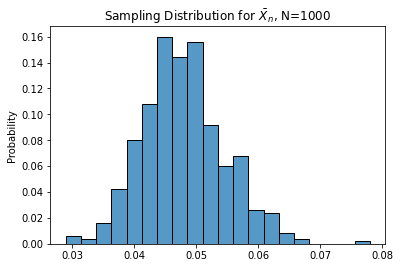

In [27]:
sns.histplot(bootstrap_sampled_mean, stat='probability')
plt.title(fr"Sampling Distribution for $\bar X_n$, N={len(samples)}")
plt.show()

Add the PDF for the empirical and theoratical distribution

In [6]:
from scipy.stats import norm

In [31]:
smean = samples.mean()
svar = samples.var() / len(samples)
sstd = np.sqrt(svar)

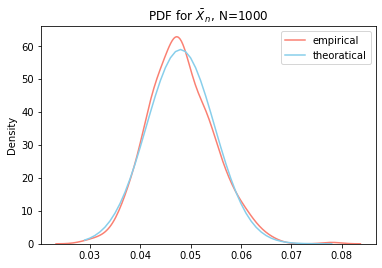

In [32]:
sns.kdeplot(bootstrap_sampled_mean, label='empirical', color='salmon')
sns.lineplot(
    x=(x := np.linspace(min(bootstrap_sampled_mean), max(bootstrap_sampled_mean))), 
    y=norm.pdf(x, loc=smean, scale=sstd),
    color='skyblue',
    label='theoratical'
)
plt.title(fr"PDF for $\bar X_n$, N={len(samples)}")
plt.legend()
plt.show()

## Hypothesis Testing

Now suppose we want to know if the mean is $p = 0.075$

We construct the belief, the null hypothesis, $H_0: p = 0.075$

Given the null hypothesis is true we construct the theoratical distribution for sampled mean.

In [66]:
true_mean = 0.065
true_se = np.sqrt(true_mean * (1-true_mean) / size)

In [75]:
x = np.linspace(true_mean - 4 * true_se, true_mean + 4 * true_se)
y = norm.pdf(x, loc=true_mean, scale=true_se)

x_fill = np.linspace(true_mean - 4 * true_se, samples.mean())
y_fill = norm.pdf(x_fill, loc=true_mean, scale=true_se)

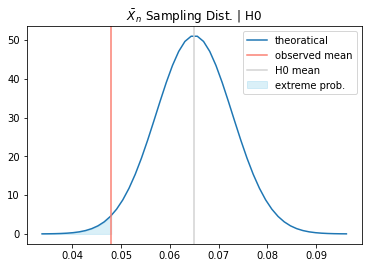

In [80]:
sns.lineplot(x=x, y=y, label='theoratical')
plt.axvline(x=samples.mean(), linestyle='-', color='salmon', label='observed mean')
plt.axvline(x=true_mean, color='lightgray', label='H0 mean')
plt.fill_between(x_fill, y_fill, color='skyblue', alpha=0.3, label='extreme prob.')

plt.title(r"$\bar X_n$ Sampling Dist. | H0")
plt.legend()
plt.show()

The shaded area is the probability of observing a realized sample mean more extreme than the current one, which is the p-value.

The smaller it gets, the more likely the null hypothesis to be false.
Then we could set a conventional threshold (e.g. 5%), then use the threshold to reject the H0.

We use conventional 5% threshold.
For two-sided test, it will be 2.5% for each side.

Now we could obtain the probability $Pr(X <= observed\_mean | H0)$

In [82]:
pvalue = norm.cdf(samples.mean(), loc=true_mean, scale=true_se)

In [84]:
print(f"The p-value is: {pvalue:.4f}")

if pvalue <= 0.025:
    print(f"Result: Reject H0")
else:
    print(f"Result: Could not reject H0")

The p-value is: 0.0146
Result: Reject H0


### Compare to the test functions from Python modules

In [97]:
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_1samp
from scipy.stats.distributions import t

In [119]:
ttest_1samp(samples, popmean=true_mean, alternative='two-sided')

Ttest_1sampResult(statistic=-2.513579192534593, pvalue=0.012107660264868304)

In [120]:
proportions_ztest(samples.sum(), len(samples), value=true_mean, alternative='two-sided')

(-2.5148369255092393, 0.01190874531462058)

Or we could implement the z-statistic on our own

In [102]:
t_statistic = (samples.mean() - true_mean) / (samples.std() / np.sqrt(len(samples)))

z_statistic = (samples.mean() - true_mean) / np.sqrt(samples.mean() * (1-samples.mean()) / len(samples)

In [103]:
z_statistic, t_statistic

(-2.5148369255092393, -2.5148369255092393)

In [123]:
norm.cdf(z_statistic, loc=0, scale=1) * 2 # for two-sided test

0.01190874531462058

In [125]:
t.cdf(t_statistic, df=len(samples), loc=0, scale=true_se) * 2 # for two-sided test

0.0